# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate, LeakyReLU, Reshape, Conv2DTranspose, Flatten, Conv2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Attention
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from utils import *

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

physical_devices = tf.config.experimental.list_physical_devices()
print("All available physical devices:", physical_devices)

# Select a GPU device for training
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    device = gpu_devices[0]
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(device, 'GPU')
    print("Selected GPU device:", device)
else:
    print("No GPU devices found.")
    

All available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU devices found.


2023-06-13 15:19:58.033284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.7/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-06-13 15:19:58.033390: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

## Load training and test data

In [3]:
# outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
# outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")
outerdata_train = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/outerdata_train_6var.npy")
outerdata_test = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/outerdata_test_6var.npy")

print(outerdata_test.shape)

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

# reserve 100,000 events for training as validation set
outerdata_train, outerdata_val = train_test_split(outerdata_train, test_size=100000, random_state=42)
print('shape of outerdata_val: ', outerdata_val.shape)

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)
og_data = data.copy()
print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
og_cond_data = cond_data.copy()
print('shape of cond_data: ', cond_data.shape)


(28876, 8)
shape of outerdata_val:  (100000, 8)
shape of data_train:  (749779, 6)
shape of data_test:  (28869, 6)
shape of data:  (778648, 6)
shape of cond_train (749779,)
shape of cond_test (28869,)
shape of cond_data:  (778648,)


In [4]:
innerdata_train = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_train_6var.npy")
innerdata_test = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_test_6var.npy")

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_test.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
og_x_SR = x_SR.copy()
print(x_SR.shape)

y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
og_y_SR = y_SR.copy()
print(y_SR.shape)

(40000, 8)
(99605, 6)
(99605,)


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [5]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [6]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [4]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend()
        plt.yscale('log')


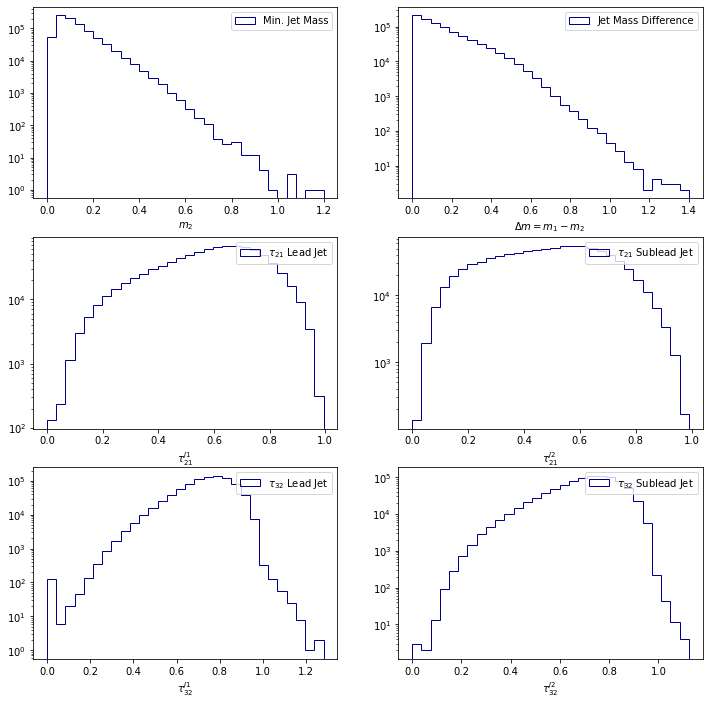

In [8]:
plot_variables(data)

In [7]:
# # scale upper and lower region of cond_data to be the same with their total size being 878648
# lower_cond_data = cond_data[cond_data <= 3.3]
# upper_cond_data = cond_data[cond_data >= 3.7]
# ratio = len(lower_cond_data)/len(upper_cond_data)
# print(ratio)
# # scale upper region to be the same as lower region
# upper_cond_data = np.random.choice(upper_cond_data, int(ratio*len(upper_cond_data)))
# print(len(upper_cond_data))
# # scale both regions to be the same size as the total size of half of cond_data
# lower_cond_data = np.random.choice(lower_cond_data, int(len(cond_data)/2))
# upper_cond_data = np.random.choice(upper_cond_data, int(len(cond_data)/2))

# cond_data = np.concatenate((lower_cond_data, upper_cond_data), axis=0)

In [7]:
# # # apply weights to upper cond_data
# lower_cond_data = cond_data[cond_data <= 3.3]
# upper_cond_data = cond_data[cond_data >= 3.7]
# ratio = len(lower_cond_data)/len(upper_cond_data)
# # # make a weights array for cond_data
# weights = np.ones(len(cond_data))
# weights[cond_data >= 3.7] = ratio
# print(weights.shape)


# cond_data = np.concatenate((lower_cond_data, upper_cond_data), axis=0)
# data = np.concatenate((lower_data, upper_data), axis=0)

(878648,)


In [6]:

# # Compute the histogram and bin edges
# hist, bin_edges = np.histogram(cond_data, bins=100)
# hist = np.where(hist == 0, 1, hist)

# # Compute the bin widths
# bin_widths = bin_edges[1:] - bin_edges[:-1]
# # Compute the desired bin height
# bin_height = 1.0

# # Compute the bin weights
# bin_weights = bin_height / (hist * bin_widths)

# # assing the proper weight to each element of cond_data based on which bin it falls into
# weights = np.ones(len(cond_data))
# for i in range(len(cond_data)):
#     for j in range(len(bin_edges)-1):
#         if cond_data[i] >= bin_edges[j] and cond_data[i] < bin_edges[j+1]:
#             weights[i] = bin_weights[j]
#             break

# print(weights.shape)

(878648,)


In [7]:
# lower cond_data 
# deco_cond_data = cond_data[cond_data <= 3.3]
# deco_cond_data, deco_cond_data_max, deco_cond_data_min  = minmax_norm_cond_data(deco_cond_data)

In [9]:
# pick a region in lower cond_data region that is the same range as signal region 
# data = data[(cond_data >= 4.5) & (cond_data <= 5.0)]
# cond_data = cond_data[(cond_data >= 4.5) & (cond_data <= 5.0)]



### Feature scaling
<!-- Dividing each feature by the `abs(maximum)` value -->

In [7]:
# lower cond_data 
# data = data[cond_data <= 3.3]
# cond_data = cond_data[cond_data <= 3.3]

#upper cond_data
# data = data[cond_data >= 3.7]
# cond_data = cond_data[cond_data >= 3.7]

#normalization
data, data_max, data_min = minmax_norm_data(data)
# x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)

# data, data_scalar = standard_norm_data(data)
# data = logit_norm(data)

# cond_data, cond_data_max, cond_data_min  = minmax_norm_cond_data(cond_data)
# cond_data, cond_data_scalar = standard_norm_cond_data(cond_data)
# cond_data = logit_norm(cond_data)

In [8]:
x_val = outerdata_val[:,1:nFeat+1]
y_val = outerdata_val[:,0]
x_val, x_val_min, x_val_max  = minmax_norm_data(x_val, minval=data_min, maxval=data_max)

x_SR, x_SR_min, x_SR_max = minmax_norm_data(x_SR, minval=data_min, maxval=data_max)

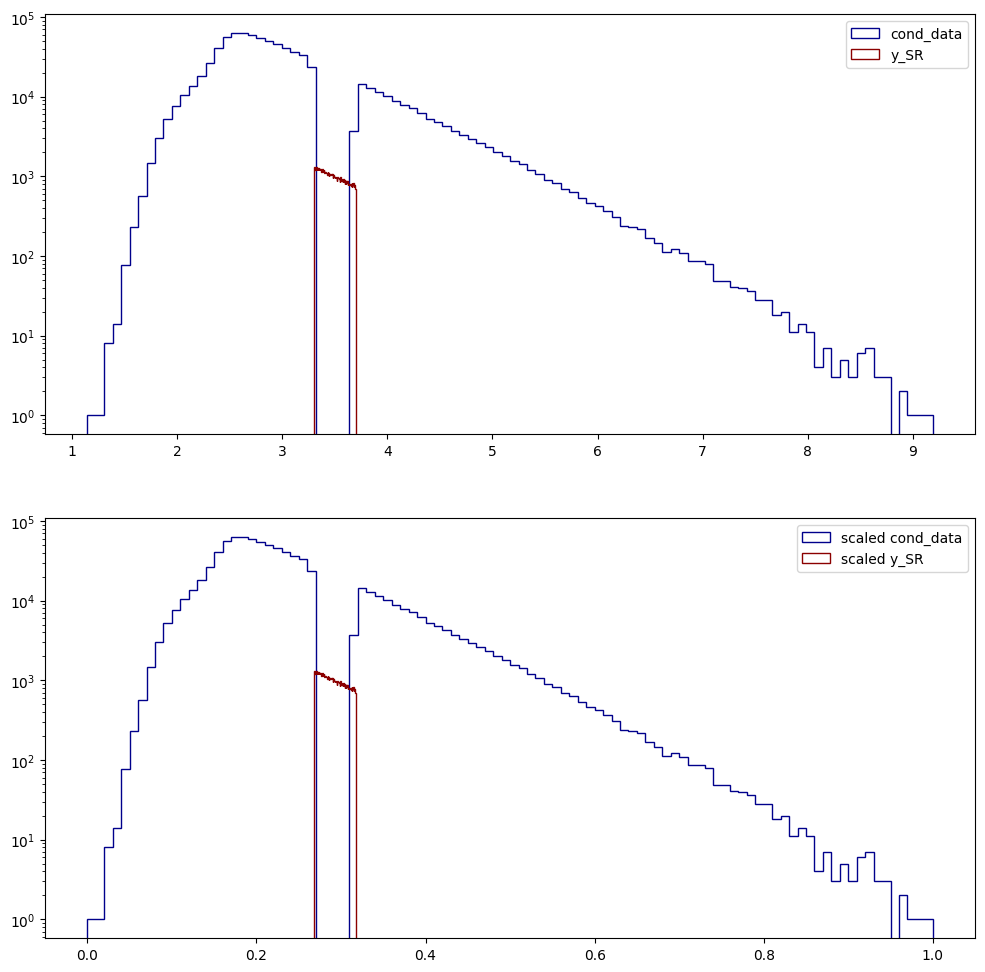

In [9]:
# combine cond_data and y_SR then apply min max normalization 
comb_cond_data = np.concatenate((cond_data, y_SR), axis=0)
comb_cond_data, comb_cond_data_max, comb_cond_data_min  = minmax_norm_cond_data(comb_cond_data)

# now seprate them again
cond_data = comb_cond_data[:len(cond_data)]
y_SR = comb_cond_data[len(cond_data):]

# plot cond_data and y_SR on same canvas before and after normalization
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.hist(og_cond_data, bins=100, color = "darkblue",  histtype = "step", label = "cond_data")
plt.hist(og_y_SR, bins=100, color = "darkred",  histtype = "step", label = "y_SR")
plt.legend()
plt.yscale('log')

plt.subplot(2, 1, 2)
plt.hist(cond_data, bins=100, color = "darkblue",  histtype = "step", label = "scaled cond_data")
plt.hist(y_SR, bins=100, color = "darkred",  histtype = "step", label = "scaled y_SR")
plt.legend()
plt.yscale('log')

plt.show()

In [10]:
hist, bin_edges = np.histogram(cond_data, bins=100)
hist = np.where(hist == 0, 1, hist)

# Compute the bin widths
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Compute the bin weights
bin_weights = (np.max(hist)/100) / (hist * bin_widths)

# Assign the proper weight to each element of cond_data based on which bin it falls into
weights = np.ones(len(cond_data))
for i in range(len(cond_data)):
    for j in range(len(bin_edges)-1):
        if cond_data[i] >= bin_edges[j] and cond_data[i] < bin_edges[j+1]:
            weights[i] = bin_weights[j]
            break


In [11]:
# #normalize the lower and upper bounds then combine them
# lower_cond_data = cond_data[cond_data <= 3.3] 
# upper_cond_data = cond_data[cond_data >= 3.7]

# lower_cond_data, lower_cond_data_max, lower_cond_data_min = minmax_norm_cond_data(lower_cond_data)
# lower_cond_data, lower_cond_data_scalar = standard_norm_cond_data(lower_cond_data)
# lower_cond_data = logit_norm(lower_cond_data)

# upper_cond_data, upper_cond_data_max, upper_cond_data_min = minmax_norm_cond_data(upper_cond_data)
# upper_cond_data, upper_cond_data_scalar = standard_norm_cond_data(upper_cond_data)
# upper_cond_data = logit_norm(upper_cond_data)

# #combined lower and upper cond_data
# cond_data = np.concatenate((lower_cond_data, upper_cond_data), axis=0)

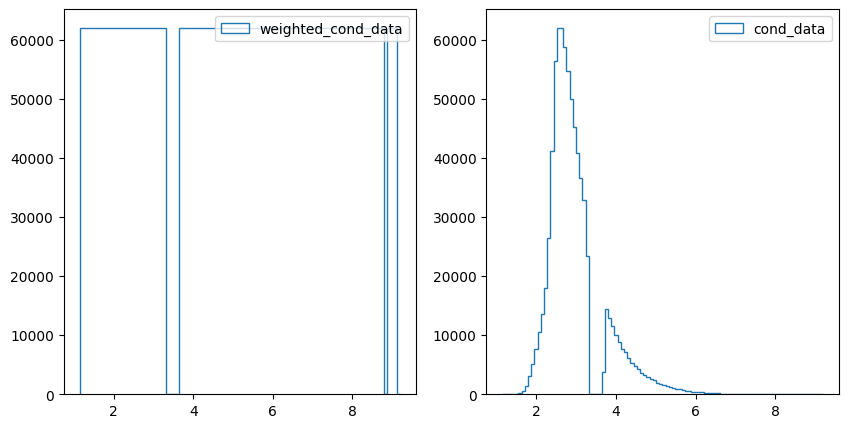

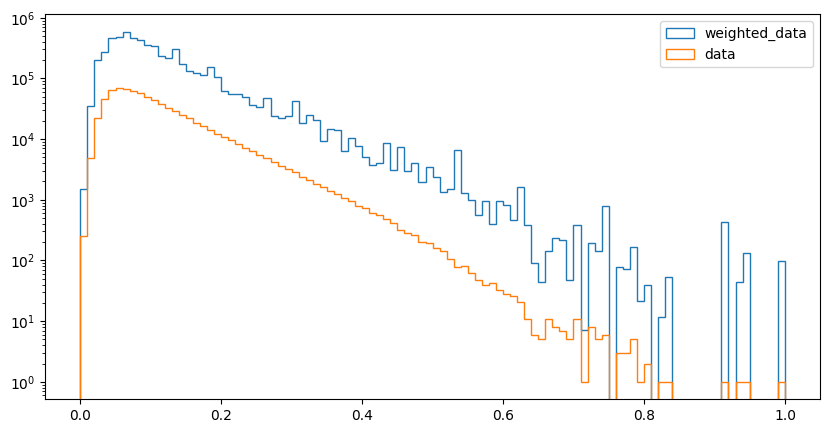

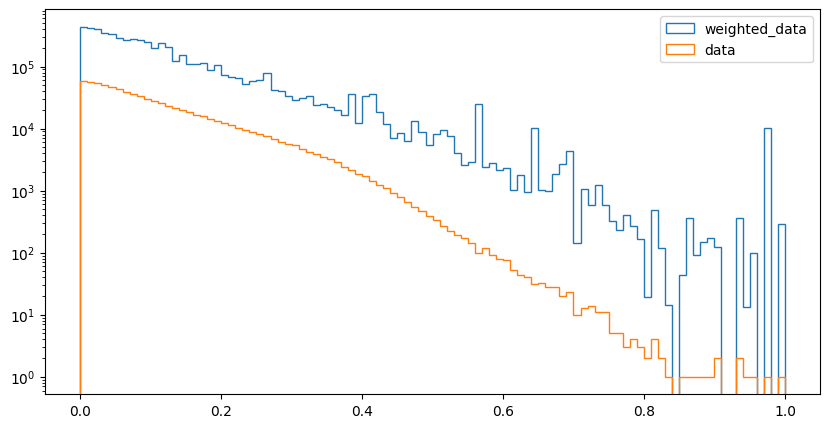

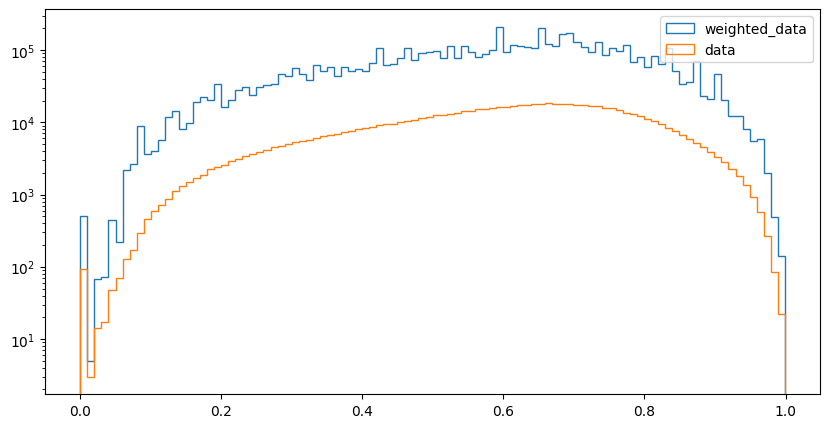

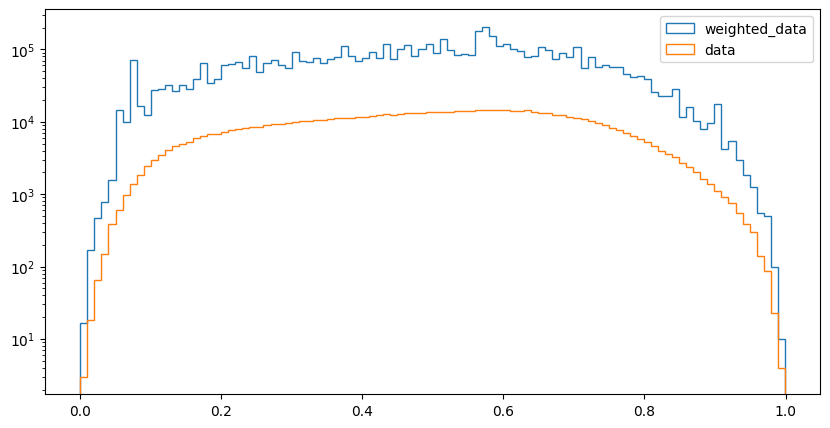

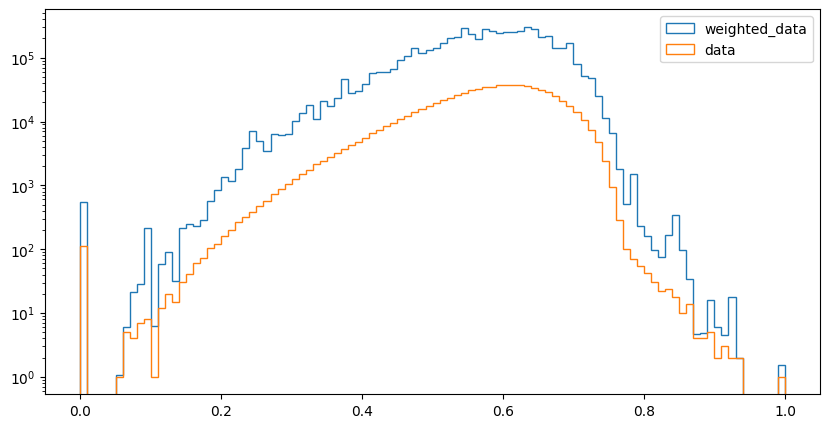

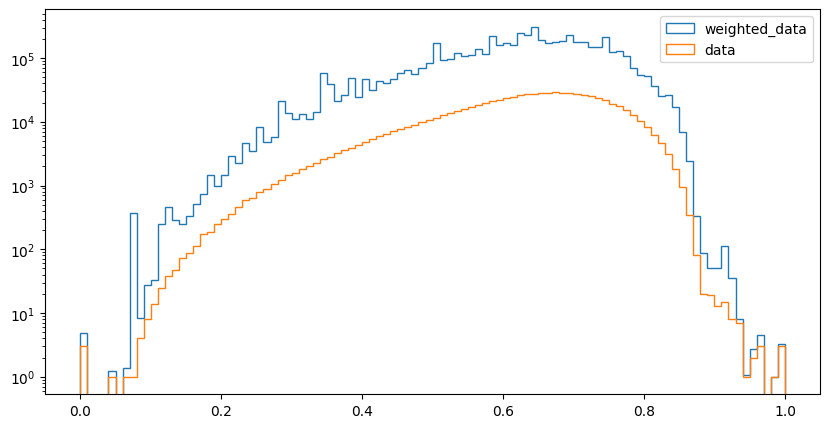

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plt.hist(og_cond_data[og_cond_data<3.3], bins=100, histtype='step', label="cond_data")
# plt.hist(cond_data, bins=100, histtype='step', label="norm_cond_data")
plt.hist(og_cond_data, bins=100, histtype='step', label="weighted_cond_data", weights=weights)

# plt.title('cond_data < 3.3 TeV')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist(og_cond_data, bins=100, histtype='step', label="cond_data")
# plt.hist(cond_data[cond_data>0.5], bins=100, histtype='step', label="norm_cond_data")
# plt.title('cond_data > 3.7 TeV')
plt.legend(loc='best')
plt.show()

#now we make the same plots as above for the each feature of normalized data, here is thec code:
for i in range(6):
    plt.figure(figsize=(10,5))
    # plt.subplot(1,2,1)
    # plt.hist(data_train[cond_data_train<3.3,i], bins=100, histtype='step', label="data")
    # print(data_train[cond_data_train<3.3,i].shape)
    # plt.hist(data[:,i], bins=100, histtype='step', label="norm_data")
    plt.hist(data[:,i], bins=100, histtype='step', label="weighted_data", weights=weights)

    # plt.title('cond_data < 3.3 TeV')
    # plt.legend(loc='best')
    # plt.subplot(1,2,2)
    plt.hist(data[:,i], bins=100, histtype='step', label="data",)
    
    # print(data_train[cond_data_train>3.7,i].shape)
    # plt.hist(data[cond_data>0.27,i], bins=100, histtype='step', label="norm_data")
    # plt.title('cond_data > 3.7 TeV')
    #log y axis 
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

## Setting up for training

### Defining the train and test sets

In [13]:
# print("Data Shape: ", np.shape(data))

# data = data[:,0:input_dim]
# # data = np.reshape(data, (len(cond_data),input_dim))
# print("Data Shape: ", np.shape(data))
# print("Data cond Shape: ", np.shape(cond_data))

# x_train = data[:trainsize]
# x_test = data[trainsize:]
# y_train = cond_data[:trainsize]
# y_test = cond_data[trainsize:]

# # x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# # x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

# # image_size = x_train.shape[1]
# # original_dim = image_size
# # x_train = np.reshape(x_train, [-1, original_dim])
# # x_test = np.reshape(x_test, [-1, original_dim])
# print("x_train Shape: ", np.shape(x_train))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# print("x_train Shape: ", np.shape(x_train))

# print("Data cond Shape: ", np.shape(y_test))
# y_train = np.reshape(y_train, [-1, 1])
# y_test = np.reshape(y_test, [-1, 1])
# print("Data cond Shape: ", np.shape(y_test))
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')

In [11]:
print("Data Shape: ", np.shape(data))
print("Data cond Shape: ", np.shape(cond_data))

trainsize = outerdata_train.shape[0]
x_train = data[:trainsize]
x_test = data[trainsize:]
y_train = cond_data[:trainsize]
y_test = cond_data[trainsize:]

weights_train = weights[:trainsize]
weights_test = weights[trainsize:]
weights_train = np.reshape(weights_train, [-1, 1])
weights_test = np.reshape(weights_test, [-1, 1])
print("weights_train Shape: ", np.shape(weights_train))

# x_train, x_test, y_train, y_test = train_test_split(data, cond_data, test_size=0.06, random_state=420)
# trainsize = x_train.shape[0]

print("x_train Shape: ", np.shape(x_train))
print("x_test Shape: ", np.shape(x_test))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("Data cond test Shape: ", np.shape(y_test))
print("Data cond train Shape: ", np.shape(y_train))
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
print("Data cond test Shape: ", np.shape(y_test))
print("Data cond train Shape: ", np.shape(y_train))

Data Shape:  (778648, 6)
Data cond Shape:  (778648,)
weights_train Shape:  (749779, 1)
x_train Shape:  (749779, 6)
x_test Shape:  (28869, 6)
Data cond test Shape:  (28869,)
Data cond train Shape:  (749779,)
Data cond test Shape:  (28869, 1)
Data cond train Shape:  (749779, 1)


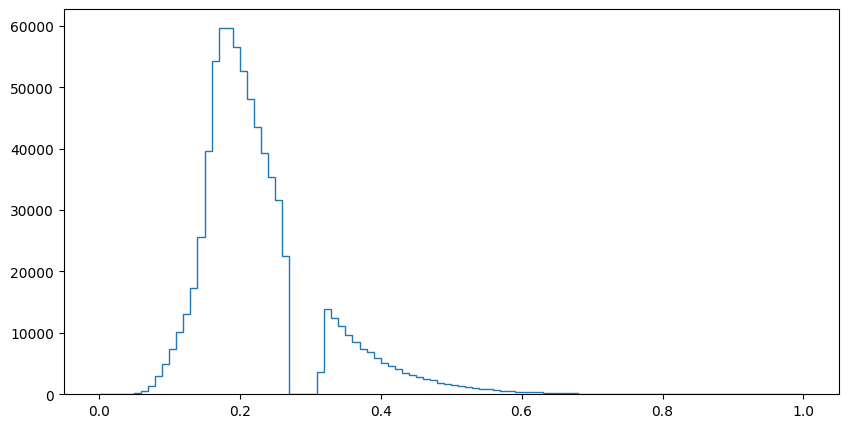

In [12]:
plt.figure(figsize=(10,5))
# plt.hist(og_cond_data[og_cond_data<3.3], bins=100, histtype='step', label="cond_data")
plt.hist(y_train, bins=100, histtype='step')
# plt.title('cond_data < 3.3 TeV')

plt.show()


### Network parameters

In [13]:
# network parameters
batch_size = 512
latent_dim = 6
epochs_1 = 200
# epochs_2 = 120

In [14]:
#note: min-max norm is present in all version
# folder_name = "cVAEz6_05-02-2023/"
folder_name = 'cVAEz4_06-13-2023_z6'
comd = "mkdir -p "+"/global/u2/a/agarabag/pscratch/GAEA/outputs/models/"+folder_name
os.system(comd)


0

### Function for Gaussian Sampling in the VAE

In [18]:

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the Encoder 

In [19]:
def create_encoder(X,y):
    
    
    inputs = Concatenate()([X, y])  
    
    # inputs_reshaped = tf.keras.layers.Reshape(target_shape=(7, 1))(inputs)
    # y_reshaped = tf.keras.layers.Reshape(target_shape=(1, 1))(y)
    # attn = Attention()([y_reshaped, inputs_reshaped])

    # x1 = Dense(32, activation='relu')(inputs)
    # # x1_reshaped = tf.keras.layers.Flatten()(x1)
    # x2 = Dense(128, activation='relu')(x1)
    # x3 = Dense(128, activation='relu')(x2)
    # x4 = Dense(32, activation='relu')(x3)
    
    x1 = Dense(32, activation='relu')(inputs)
    x2 = Dense(64, activation='relu')(x1)
    x4 = Dense(32, activation='relu')(x2)
    
    z_mean = Dense(latent_dim, name='z_mean')(x4)
    z_log_var = Dense(latent_dim, name='z_log_var')(x4)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return Model([X, y], [z_mean, z_log_var,  z], name='encoder')

### Define the Decoder

In [20]:
def create_decoder(z,y):
    latent_inputs = Concatenate()([z, y])
    
    # inputs_reshaped = tf.keras.layers.Reshape(target_shape=(7, 1))(latent_inputs)
    # y_reshaped = tf.keras.layers.Reshape(target_shape=(1, 1))(y)
    # attn = Attention()([y_reshaped, inputs_reshaped])
    
    # x1 = Dense(32, activation='relu')(latent_inputs)
    # # x1_reshaped = tf.keras.layers.Flatten()(x1)
    # x2 = Dense(128, activation='relu')(x1)
    # x3 = Dense(128, activation='relu')(x2_dropout)
    # x4 = Dense(32, activation='relu')(x3dropout)
    
    x1 = Dense(32, activation='relu')(latent_inputs)
    x2 = Dense(64, activation='relu')(x1)
    x4 = Dense(32, activation='relu')(x2)
    
    outputs = Dense(input_dim, activation='linear')(x4)

    return Model([z, y], outputs, name='decoder')

In [21]:
# instantiate encoder model
encoder = create_encoder(Input(shape=(input_dim,)), Input(shape=(1,)))
encoder.summary()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           256         concatenate[0][0]          

In [22]:
# instantiate decoder model
decoder = create_decoder(Input(shape=(latent_dim,)), Input(shape=(1,)))
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 7)            0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           256         concatenate_1[0][0]        

### Define the full VAE model

In [23]:
X_input = Input(shape=(input_dim,))
y_input = Input(shape=(1,))

w_input = Input(shape=(1,))

z_mean, z_log_var, z = encoder([X_input,y_input])
outputs = decoder([z,y_input])

cvae = Model([X_input, y_input, w_input], outputs)
#cvae = Model([X_input, y_input], outputs)

### Define the loss functions

In [24]:
def mse_loss_fn(x, x_decoded_mean):
#     mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)

    # mse_loss = tf.reduce_mean(
    #         tf.reduce_sum(
    #             keras.losses.mse(x, x_decoded_mean)
    #         )
    #     )
    #mse_loss = tf.reduce_mean(keras.losses.mse(x, x_decoded_mean))
    mse_loss = K.mean(K.square(x - x_decoded_mean)*w_input)
    return mse_loss
    
def kl_loss_fn(x,  x_decoded_mean):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss
            

def vae_loss(x, x_decoded_mean):
#         mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = mse_loss_fn(x, x_decoded_mean)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    beta = 0.005
    #beta = 0.005 #z3
    # loss = K.mean(((1-beta)*mse_loss + beta*kl_loss)*w_input)
    loss = K.mean((1-beta)*mse_loss + beta*kl_loss)

    return loss


### Custom Saver function

In [25]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        # if ((k == (iterations-1)):
        if (epoch+1)%10 == 0:
            decoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
            encoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
decoderSaver = CustomSaver()

In [26]:
# class CustomSaver(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         print("Epoch: ", epoch) 
#         if epoch > 0 and epoch % 10 == 0:
#             decoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
#             encoder.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
# decoderSaver = CustomSaver()

### Other network parameters and model compilation

In [27]:
learnrate = 0.0025 #for z6
#learnrate = 0.0008 #for z4
#learnrate = 0.00094 #for z3

iterations = 3
lr_limit = learnrate/(2**iterations)
history = History()
k=0

In [28]:
checkpointer = ModelCheckpoint(filepath='/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)
opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cvae.compile(optimizer=opt, loss=vae_loss)
cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 6), (None, 6 4844        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                        

In [95]:
# list_loss = []
# list_val_loss = [] 

# # create the optimizer instances
# adam_opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd_opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)

# checkpointer = ModelCheckpoint(filepath='/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)

# # create the ReduceLROnPlateau callback
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, verbose=1)

# for epoch in range(100):
#     if epoch <= 70:
#         cvae.compile(loss=vae_loss, optimizer=adam_opt, metrics=[mse_loss_fn, kl_loss_fn])
#         history = cvae.fit([x_train, y_train], x_train,
#          epochs=epoch+1,
#          batch_size=batch_size,
#          validation_data=([x_test, y_test], x_test),
#          callbacks=[checkpointer, reduce_lr])
#         cvae.load_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))
#     else:
#         # switch to SGD optimizer
#         cvae.compile(loss=vae_loss, optimizer=sgd_opt, metrics=[mse_loss_fn, kl_loss_fn])
#         # continue fitting with SGD optimizer
#         history = cvae.fit([x_train, y_train], x_train,
#          epochs=epoch+1,
#          batch_size=batch_size,
#          validation_data=([x_test, y_test], x_test),
#          callbacks=[checkpointer, reduce_lr])
#         cvae.load_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

#     list_loss = np.append(list_loss, history.history['loss'])
#     list_val_loss = np.append(list_val_loss, history.history['val_loss'])
#     if epoch > 0:
#         decoderSaver.on_epoch_end(epoch)

# cvae.save_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))

In [29]:
list_loss = []
list_val_loss = [] 
cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
cvae.fit([x_train, y_train, weights_train], x_train,   
        epochs=epochs_1,
        batch_size=batch_size,
        validation_data=([x_test, y_test, weights_test], x_test),
        callbacks = [checkpointer, history, decoderSaver], verbose=0)

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])


2023-06-13 13:34:12.781371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.16721, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_06-13-2023_z6/cbvae_LHCO2020_20d_e-6.hdf5

Epoch 00002: val_loss improved from 0.16721 to 0.08406, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_06-13-2023_z6/cbvae_LHCO2020_20d_e-6.hdf5

Epoch 00003: val_loss improved from 0.08406 to 0.06165, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_06-13-2023_z6/cbvae_LHCO2020_20d_e-6.hdf5

Epoch 00004: val_loss did not improve from 0.06165

Epoch 00005: val_loss did not improve from 0.06165

Epoch 00006: val_loss improved from 0.06165 to 0.04948, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_06-13-2023_z6/cbvae_LHCO2020_20d_e-6.hdf5

Epoch 00007: val_loss improved from 0.04948 to 0.04673, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz4_06-13-2023_z6/cbvae_LHCO2020_20d_e-6.hdf5

Epoch 00008: val_loss improved fro

## Training loop

In [ ]:
list_loss = []
list_val_loss = [] 

while learnrate > lr_limit:
    # if k < 4:
    #     opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #     epochs = epochs_1
    # else:
    #     opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)
    #     epochs = epochs_2
    
    #Using only one opt
    opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    epochs = epochs_1
    
    cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
    cvae.fit([x_train, y_train], x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks = [checkpointer, history, decoderSaver])
    cvae.load_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

    learnrate /= 2
    k=k+1

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])

    
cvae.save_weights('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))



Train on 731929 samples, validate on 46719 samples


2023-05-01 23:56:02.526720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 23:56:03.338094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33789 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Epoch 1/100
 11776/731929 [..............................] - ETA: 1:38 - loss: 58.1086 - mse_loss_fn: 58.2483 - kl_loss_fn: 0.0349

2023-05-01 23:56:05.212220: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


731648/731929 [============================>.] - ETA: 0s - loss: 5.9352 - mse_loss_fn: 5.9203 - kl_loss_fn: 12.1366

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.15734, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz6_05-01-2023_v2/cbvae_LHCO2020_20d_e-6.hdf5
731929/731929 [==============================] - 17s 23us/sample - loss: 5.9334 - mse_loss_fn: 5.9170 - kl_loss_fn: 12.1385 - val_loss: 1.1573 - val_mse_loss_fn: 1.1118 - val_kl_loss_fn: 17.1935
Epoch 2/100
730112/731929 [============================>.] - ETA: 0s - loss: 1.6761 - mse_loss_fn: 1.6348 - kl_loss_fn: 18.8293
Epoch 00002: val_loss improved from 1.15734 to 0.92911, saving model to /global/u2/a/agarabag/pscratch/GAEA/outputs/models/cVAEz6_05-01-2023_v2/cbvae_LHCO2020_20d_e-6.hdf5
731929/731929 [==============================] - 9s 13us/sample - loss: 1.6753 - mse_loss_fn: 1.6337 - kl_loss_fn: 18.8321 - val_loss: 0.9291 - val_mse_loss_fn: 0.8782 - val_kl_loss_fn: 19.8810
Epoch 3/100
728064/731929 [============================>.] - ETA: 0s - loss: 1.3119 - mse_loss_fn: 1.2655 - kl_loss_fn: 20.5970
Epoch 00003: v

In [23]:
#this endocer and decoder is same as the ones used in above cell to save mean and std
folder = "/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s"%folder_name
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m199.h5')
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m199.h5')

# latent mean
# mean = encoder.predict([x_train, y_train])[0]
# # latent log variance --> variance --> std
# latent_logvar = encoder.predict([x_train, y_train])[1]
# latent_var = np.exp(latent_logvar)
# std = np.sqrt(latent_var)

2023-06-13 15:02:14.245672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.7/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.7/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-06-13 15:02:14.245800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

In [31]:
# Predict the mean and std from the training dataset
# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, latent_mean)
np.savetxt('/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
np.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
np.save("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

In [32]:
list_loss.shape

(200,)

(200,)
0.04135086246237287


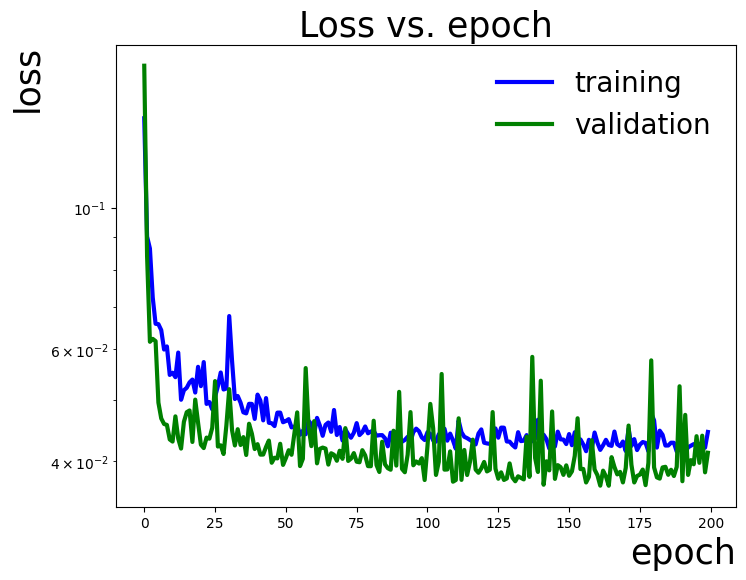

In [16]:
# plot loss function
list_val_loss = np.load("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name)
list_loss = np.load("/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name)
print(list_loss.shape)
print(np.min(list_loss))
fig, ax = plt.subplots(1,1, figsize=(8,6))

# plt.plot(np.arange(0,epochs_1*iterations), list_loss, label='training',c='blue',linewidth = 3)
# plt.plot(np.arange(0,epochs_1*iterations), list_val_loss, label='validation',c='red',linewidth = 3)
plt.plot(np.arange(0,200), list_loss, label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,200), list_val_loss, label='validation',c='green',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
#log scale y axis
ax.set_yscale('log')
#set x limit
# ax.set_ylim(0, 5)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [15]:
# Read the mean values
filename = '/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name
means_df = pd.read_csv(filename, sep=' ', header=None)
mean = means_df.values


print(mean.shape)

# Read the std values
filename = '/global/u2/a/agarabag/pscratch/GAEA/outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name
stds_df = pd.read_csv(filename, sep=' ', header=None)
std = stds_df.values

(749779, 6)


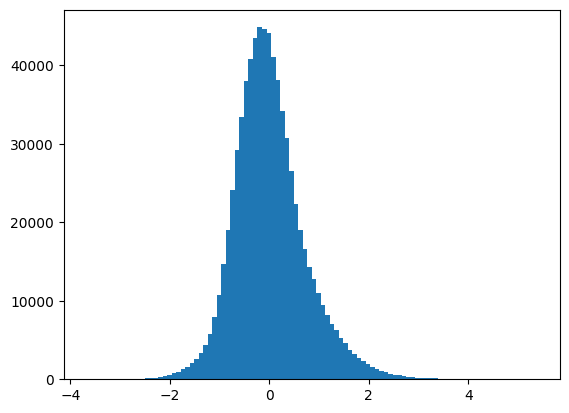

In [19]:
plt.hist(mean[:,5], bins=100)
# plt.yscale('log')
plt.show()

In [37]:
cond_data.shape
# plt.hist(cond_data, bins=50)

(778648,)

In [24]:
z_samples = np.empty([cond_data.shape[0],latent_dim])
l=0
for i in range(0,cond_data.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1

# use normal gaussian as z 
# z_samples = np.random.normal(size=(cond_data.shape[0], latent_dim))

gen_SB = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

#reverse normalization
# new_events = expit_norm(new_events)
# gen_SB = rev_minmax_data(gen_SB, data_min, data_max)

# os.system("mkdir -p /global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/"%folder_name)
# np.save('/global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name, new_events)

2023-06-13 15:02:42.131174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:

# Obtain latent space using encoder
latent_data = np.concatenate([mean, std], axis=1)
print(mean.shape, std.shape, latent_data.shape)
# print(mean)
# print("######################")
# print(std)
# print("######################")
# print(latent_data)

#Fit Gaussian mixture model on latent space
gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=42)
gmm.fit(latent_data)


(849779, 6) (849779, 6) (849779, 12)


GaussianMixture(n_components=100, random_state=42)

In [14]:
#save GMM
np.save('outputs/gen_dataset/%s/SB_gmm_weights'%folder_name, gmm.weights_, allow_pickle=False)
np.save('outputs/gen_dataset/%s/SB_gmm_means'%folder_name, gmm.means_, allow_pickle=False)
np.save('outputs/gen_dataset/%s/SB_gmm_cov'%folder_name, gmm.covariances_, allow_pickle=False)

In [17]:
# reload gmm
means = np.load('outputs/gen_dataset/%s/SB_gmm_means.npy'%folder_name)
covar = np.load('outputs/gen_dataset/%s/SB_gmm_cov.npy'%folder_name)
loaded_gmm = GaussianMixture(n_components = len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load('outputs/gen_dataset/%s/SB_gmm_weights.npy'%folder_name)
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

new_z_samples = loaded_gmm.sample(cond_data.shape[0])

In [18]:
# Sample new latent vectors from the GMM
# new_z_samples = gmm.sample(cond_data.shape[0])

z_samples = np.array(new_z_samples[0])[:, :6]

# Decode the sampled latent vectors to generate new data points
new_events = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])

new_events = rev_minmax_data(new_events, data_min, data_max)

# os.system("mkdir -p ./outputs/gen_dataset/%s/"%folder_name)
np.save('outputs/gen_dataset/%s/LHCO2020_cB-VAE_gmm_z_events_lower_new_SB.npy'%folder_name, new_events)

In [17]:
print(z_samples.shape)
# print(np.reshape(cond_data, [-1, 1]).shape)

(878648, 6)


0.0008401675550427702 1.0019515740122147


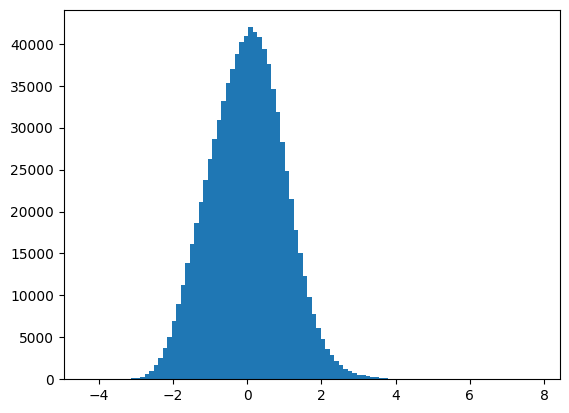

In [30]:
idx = 2
plt.hist(z_samples[:, idx], bins=100)
print(np.mean(z_samples[:, idx]), np.std(z_samples[:, idx]))

In [12]:
file_gen_SB = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.npy'%folder_name
gen_SB = np.load(file_gen_SB)
# gen_SB = pd.read_csv(file_gen_SB, delimiter = ' ', header=None, index_col=False)
# gen_SB = gen_SB.to_numpy()
print("shape of gen_SR: ", gen_SB.shape)


shape of gen_SR:  (878648, 6)


In [25]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="MC Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        # ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        # plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

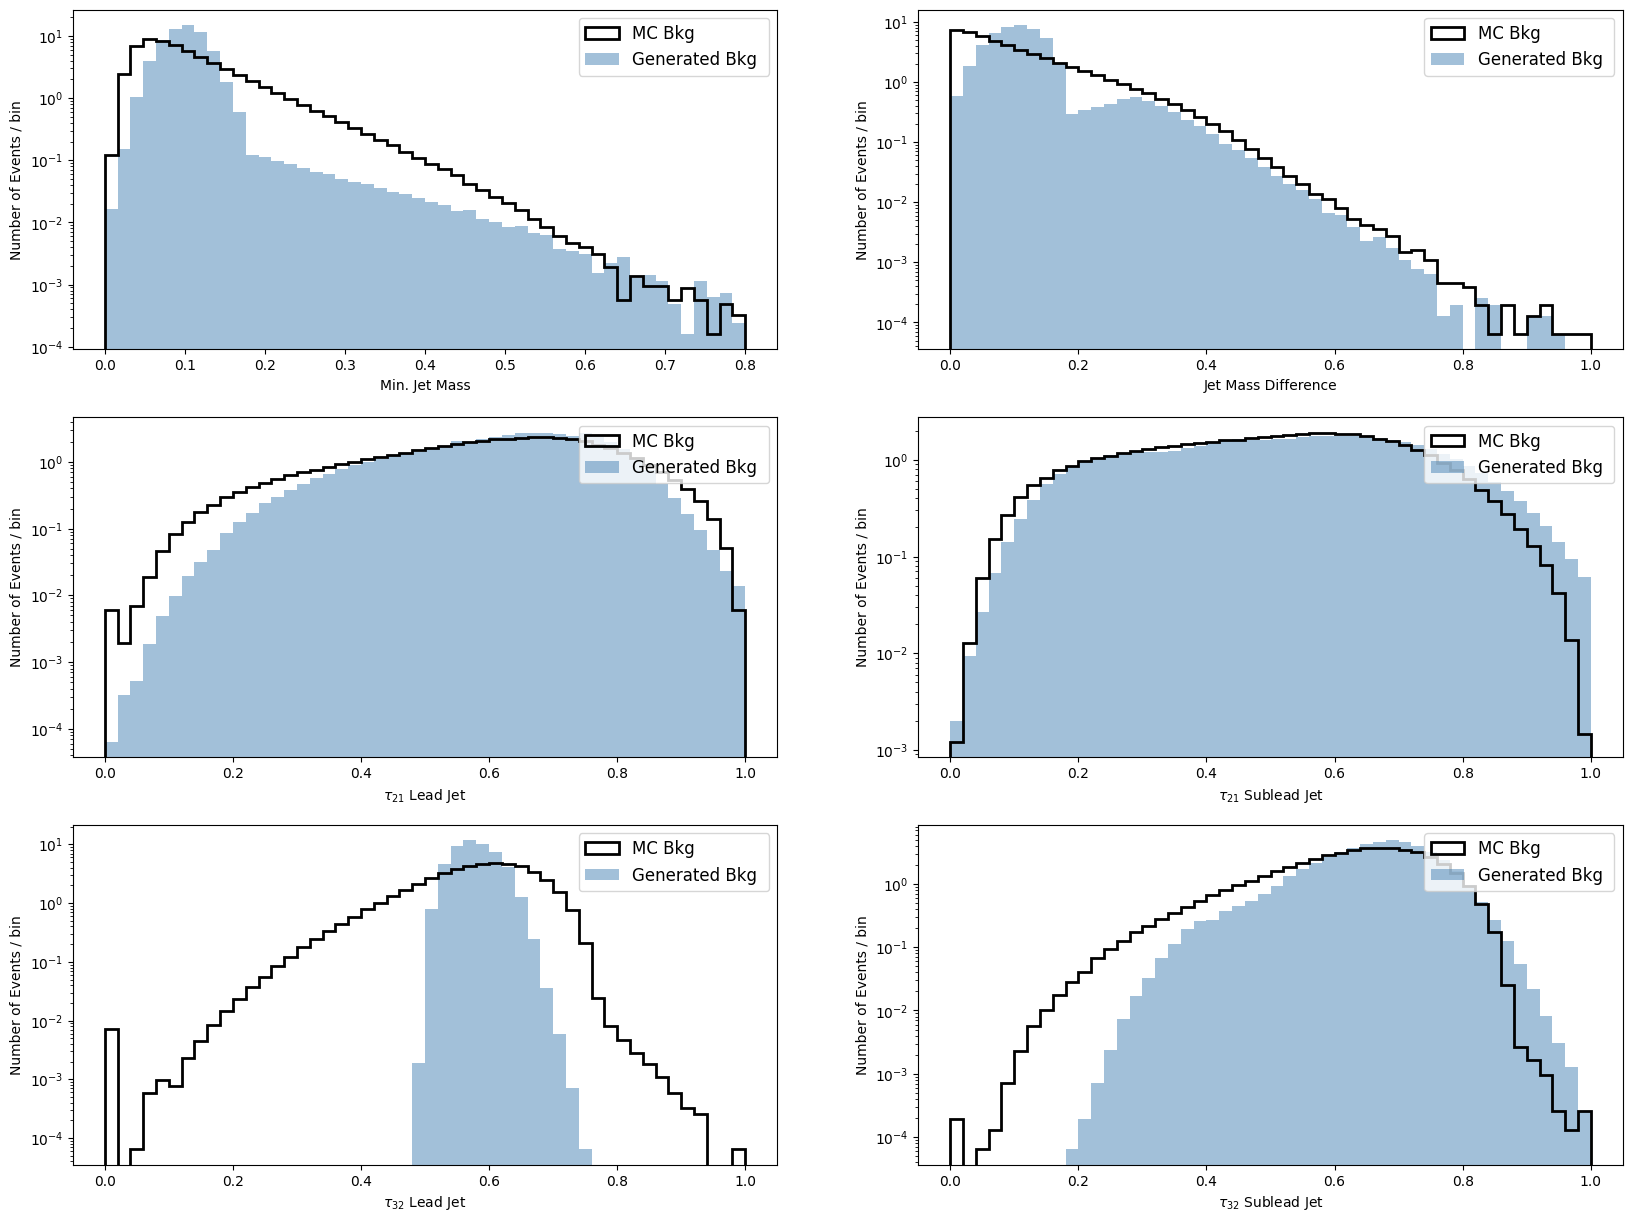

In [26]:
fake_vs_real([gen_SB],[data],1,[""])

In [23]:
innerdata_train = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_train_6var.npy")
innerdata_test = np.load("/global/u2/a/agarabag/pscratch/GAEA/data/preprocessed_data_6var_more_training_data/innerdata_test_6var.npy")

innerdata_train = innerdata_train[innerdata_train[:,nFeat+1]==0]
innerdata_test  = innerdata_test[innerdata_test[:,nFeat+1]==0]
print(innerdata_test.shape)

data_sr_train = innerdata_train[:,1:nFeat+1]
data_sr_test = innerdata_test[:,1:nFeat+1]
x_SR = np.concatenate((data_sr_train, data_sr_test), axis=0)
print(x_SR.shape)
x_SR, x_SR_max, x_SR_min = minmax_norm_data(x_SR)
# x_SR = logit_norm(x_SR)


y_innerdata_train = innerdata_train[:,0]
y_innerdata_test = innerdata_test[:,0]
y_SR = np.concatenate((y_innerdata_train, y_innerdata_test), axis=0)
y_SR, cond_data_SR_max, cond_data_SR_min = minmax_norm_cond_data(y_SR)
# y_SR = logit_norm(y_SR)
print(y_SR.shape)

(40000, 8)
(99605, 6)
(99605,)


In [18]:
from sklearn.neighbors import KernelDensity

# Generate SR data 
KDE_bandwidth = 0.01
mjj_logit = quick_logit(y_SR)
y_SR_new = logit_transform_inverse(KernelDensity(
                  bandwidth=KDE_bandwidth, kernel='gaussian').fit(
                  mjj_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
                                                   max(y_SR).item(),
                                                   min(y_SR).item())
#y_SR_new = KernelDensity(bandwidth=KDE_bandwidth, kernel='gaussian').fit(y_SR.reshape(-1, 1)).sample(z_samples.shape[0])


gen_SR = decoder.predict([z_samples, np.reshape(y_SR_new, [-1, 1])])

# gen_SR = rev_minmax_data(gen_SR, x_SR_min, x_SR_max)

# np.save('/global/u2/a/agarabag/pscratch/GAEA/outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SR.npy'%folder_name, gen_SR)

In [20]:
rand_y = np.random.normal(size=(cond_data.shape[0],1))

In [21]:
rand_y.shape

(878648, 1)

In [22]:
rand_gen = decoder.predict([z_samples, rand_y])

In [23]:
sub_cond_data = cond_data[(cond_data >= 0.4) & (cond_data <= 0.45)]


In [31]:
sub_data = data[(cond_data >= 0.4) & (cond_data <= 0.45)]


In [25]:
sub_z_samples = np.empty([sub_cond_data.shape[0],latent_dim])
l=0
for i in range(0,sub_cond_data.shape[0]):
    for j in range(0,latent_dim):
        sub_z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
sub_gen = decoder.predict([sub_z_samples, np.reshape(sub_cond_data, [-1, 1])])

In [37]:
lower_sub_cond_data = cond_data[(cond_data >= 0.1) & (cond_data <= 0.15)]
lower_sub_data = data[(cond_data >= 0.1) & (cond_data <= 0.15)]


In [38]:
lower_sub_z_samples = np.empty([lower_sub_cond_data.shape[0],latent_dim])
l=0
for i in range(0,lower_sub_cond_data.shape[0]):
    for j in range(0,latent_dim):
        lower_sub_z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
lower_sub_gen = decoder.predict([lower_sub_z_samples, np.reshape(lower_sub_cond_data, [-1, 1])])

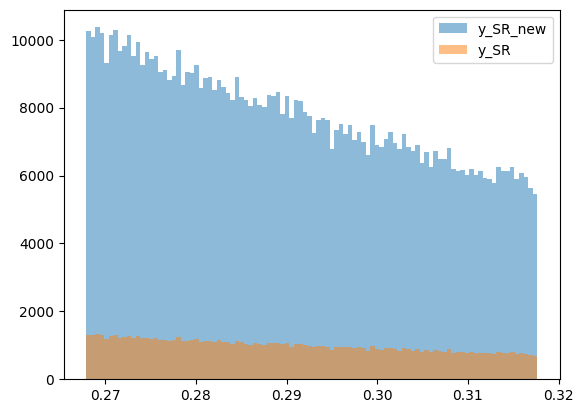

In [22]:
# plot cond_data and y_SR together
plt.hist(y_SR_new , bins=100, alpha=0.5, label="y_SR_new")
plt.hist(y_SR, bins=100, alpha=0.5, label="y_SR")
plt.legend(loc='upper right')

plt.show()

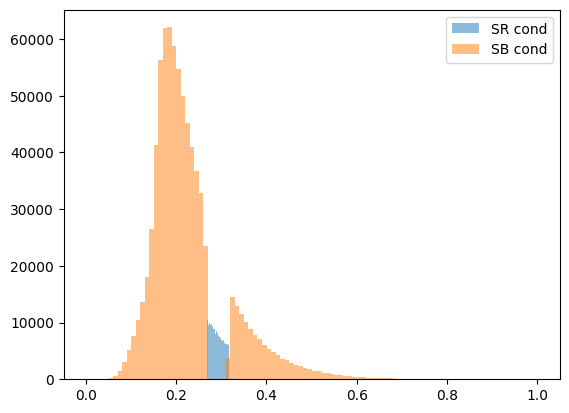

In [23]:
# plot cond_data and y_SR together
plt.hist(y_SR_new , bins=100, alpha=0.5, label="SR cond")
plt.hist(cond_data, bins=100, alpha=0.5, label="SB cond")
plt.legend(loc='upper right')

plt.show()

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.6.0/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


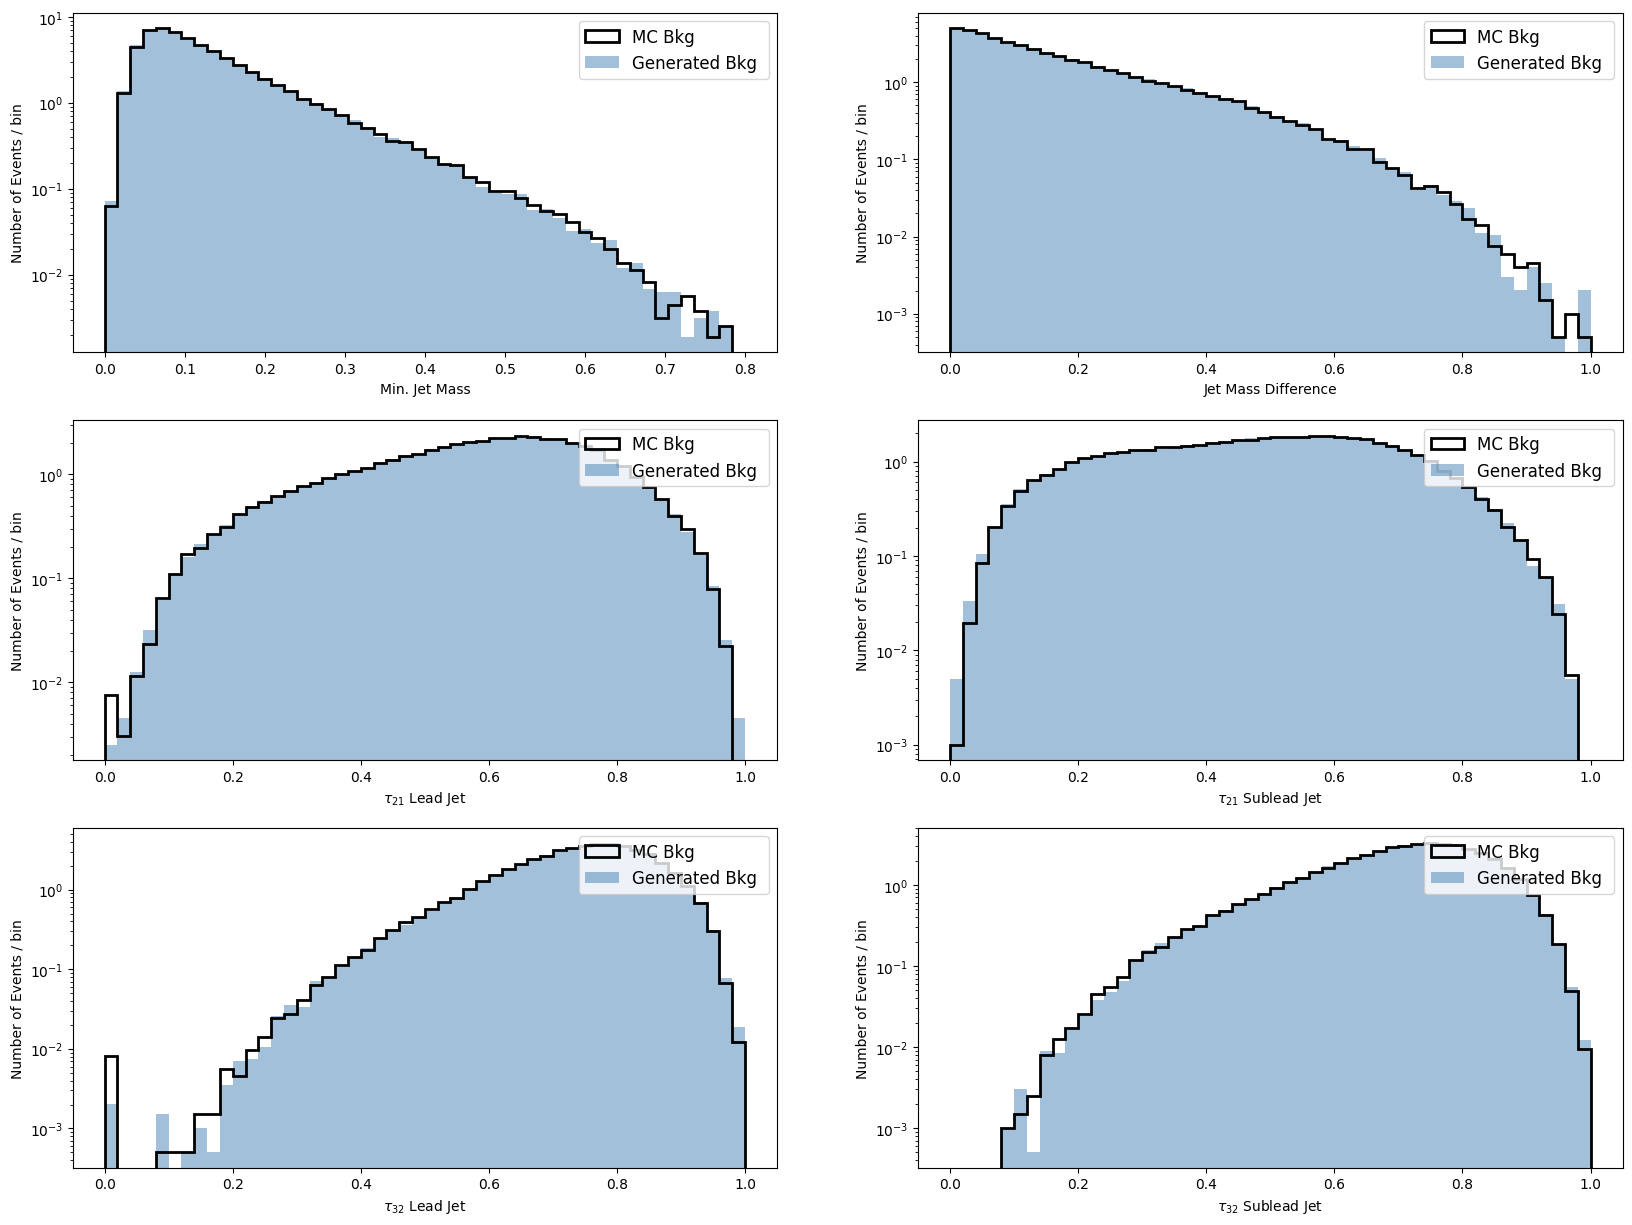

In [20]:
from sklearn.neighbors import KernelDensity
KDE_bandwidth = 0.01

#this endocer and decoder is same as the ones used in above cell to save mean and std
folder = "/global/homes/a/agarabag/pscratch/GAEA/outputs/models/cVAEz6_04-06-2023"
encoder = keras.models.load_model(folder+'/encoder_cbvae_6var_m999.h5')
decoder = keras.models.load_model(folder+'/model_cbvae_6var_m999.h5')

# y_train_sr = KernelDensity(bandwidth=KDE_bandwidth, kernel='gaussian').fit(y_SR.reshape(-1, 1)).sample(y_train.shape[0])
# y_train_sr = y_train_sr.astype('float32')
# y_train_sr = np.random.lognormal(size=(y_train.shape[0], 1))
x = x_SR[:innerdata_train.shape[0]].astype('float32')
y = y_SR[:innerdata_train.shape[0]].astype('float32')
# latent mean
mean = encoder.predict([x, y])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x, y])[1]
latent_var = np.exp(latent_logvar)
std = np.sqrt(latent_var)

trainsize = innerdata_train.shape[0]


z_samples = np.empty([y_SR.shape[0],latent_dim])
l=0
for i in range(0,y_SR.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1

# mjj_logit = quick_logit(y_SR)
# y_SR = logit_transform_inverse(KernelDensity(
#                   bandwidth=KDE_bandwidth, kernel='gaussian').fit(
#                   mjj_logit.reshape(-1, 1)).sample(z_samples.shape[0]),
#                                                    max(y_SR).item(),
#                                                    min(y_SR).item())
y_SR = KernelDensity(bandwidth=KDE_bandwidth, kernel='gaussian').fit(y_SR.reshape(-1, 1)).sample(z_samples.shape[0])

# x_SR_train = x_SR[:trainsize]
# image_size = x_SR_train.shape[1]
# original_dim = image_size
# x_SR_train = np.reshape(x_SR_train, [-1, original_dim])

# print(x_SR_train.shape)
# print(z_samples.shape)
# print(np.reshape(y_SR, [-1, 1]).shape)

gen_SR = decoder.predict([z_samples, np.reshape(y_SR, [-1, 1])])
#gen_SR = decoder.predict([np.random.lognormal(size=(cond_data.shape[0], 6)), np.reshape(y_SR, [-1, 1])])

gen_SR = rev_minmax_data(gen_SR, x_SR_min, x_SR_max)

# np.save('outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_upper_SR.npy'%folder_name, gen_SR)

fake_vs_real([gen_SR],[rev_minmax_cond_data(x_SR, x_SR_min, x_SR_max)],1,[""])

In [19]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real2(gen_data, mc_sb_data, mc_sr_data, doLog, names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SB_MC", density=True)        
        for rd in mc_sr_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="red", histtype='step', linewidth=2, label="SR_MC", density=True)
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Gen Bkg %s"%names[i], density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")


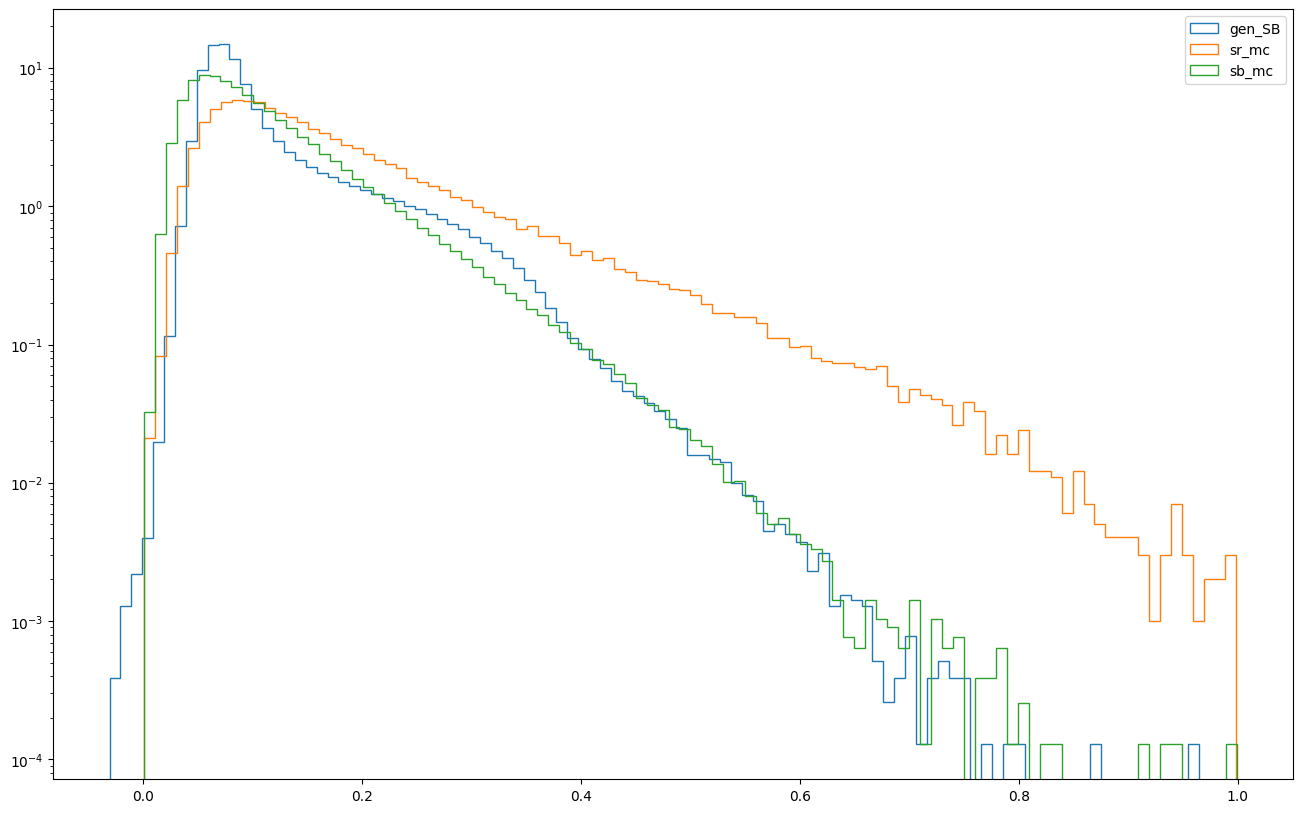

In [39]:

plt.figure(figsize=(16,10))
f_num = 0
# plt.hist(rand_gen[:,f_num], bins=100, histtype='step', label="rand_gen", density=True)
# plt.hist(sub_gen[:,f_num], bins=100, histtype='step', label="upper_sub_gen", density=True)
# plt.hist(lower_sub_gen[:,f_num], bins=100, histtype='step', label="lower_sub_gen", density=True)
# plt.hist(gen_SR[:,f_num], bins=100, histtype='step', label="gen_SR", density=True)
plt.hist(gen_SB[:,f_num], bins=100, histtype='step', label="gen_SB", density=True)


# plt.hist(sub_data[:, f_num], bins=100, histtype='step', label="upper_sub_sb_mc", density=True)
# plt.hist(lower_sub_data[:, f_num], bins=100, histtype='step', label="lower_sub_sb_mc", density=True)
plt.hist(x_SR[:, f_num], bins=100, histtype='step', label="sr_mc", density=True)
plt.hist(data[:, f_num], bins=100, histtype='step', label="sb_mc", density=True)

plt.yscale('log')
plt.legend()

plt.show()


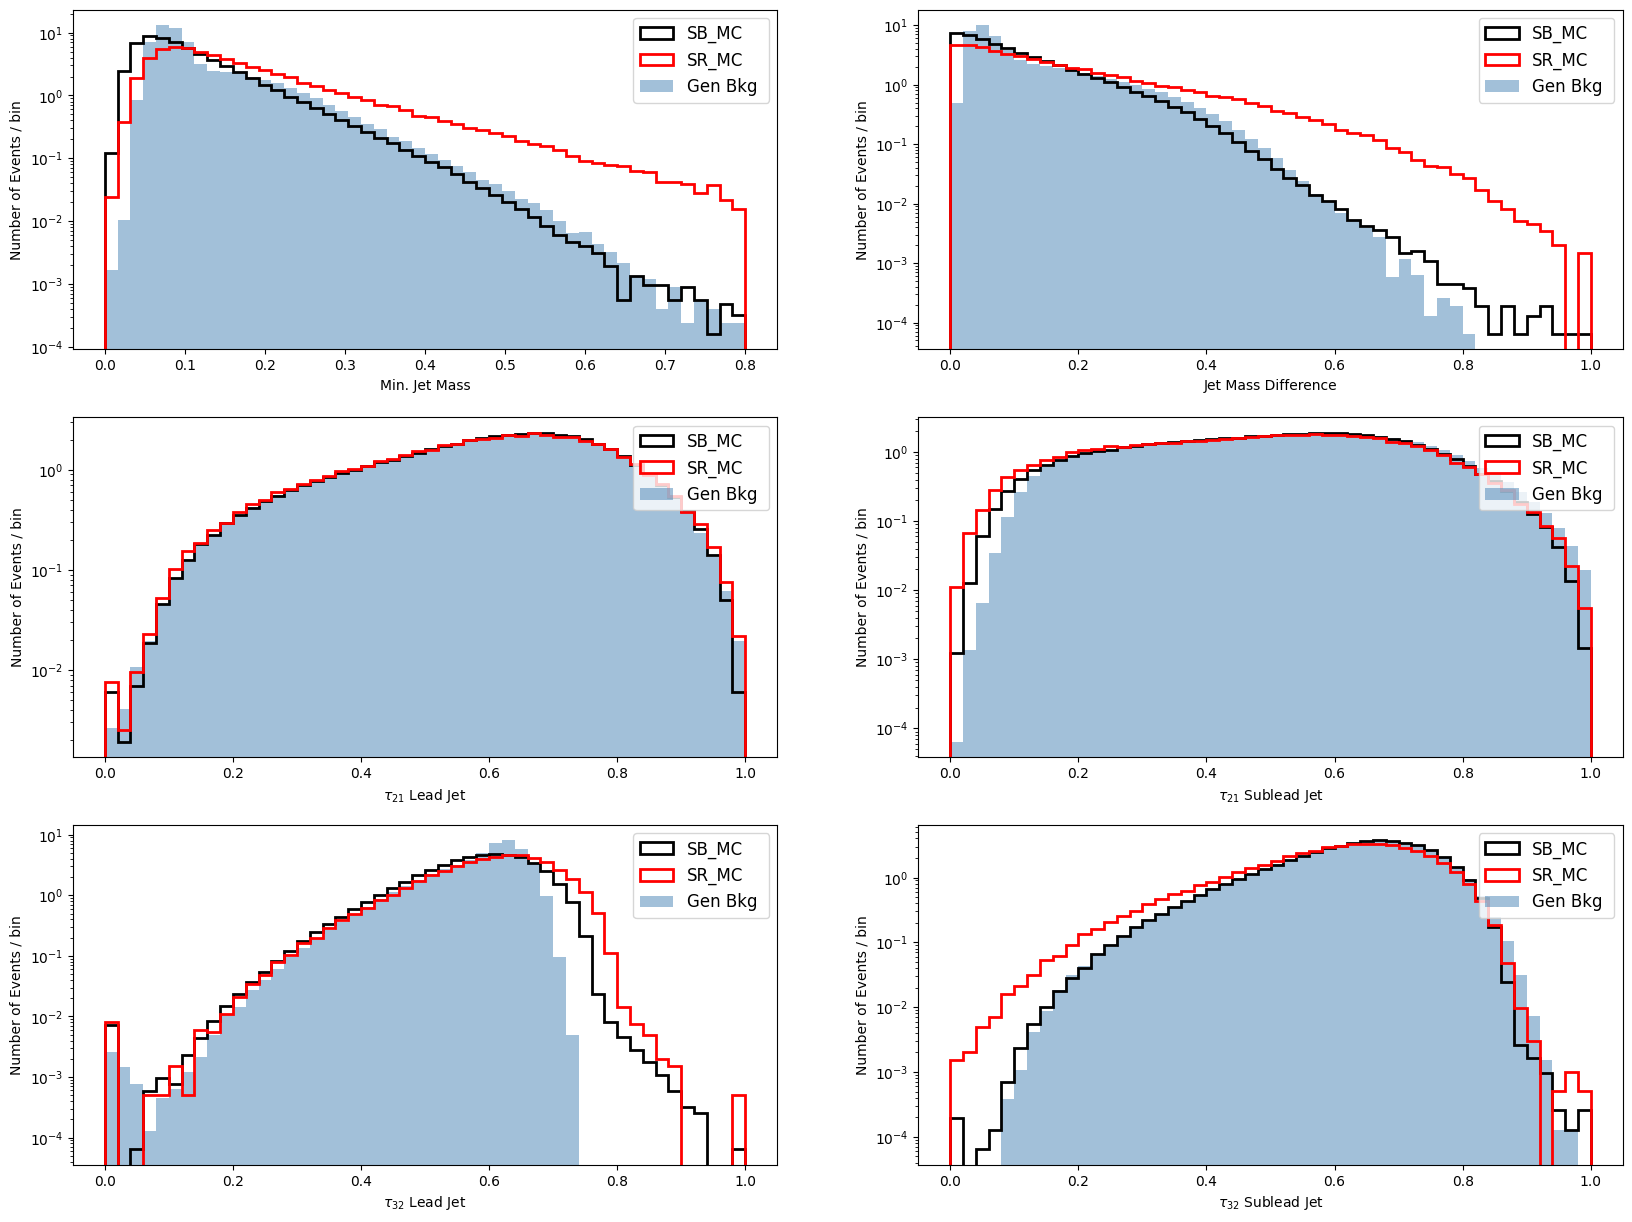

In [20]:
# file_gen_SR = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_gmm_z_events_SR.npy'%folder_name
# gen_SR = np.load(file_gen_SR)
# fake_vs_real2([gen_SR],[un_norm_data],[rev_minmax_data(x_SR, x_SR_min, x_SR_max)],1,[""])
# fake_vs_real2([rev_minmax_data(gen_SR, x_SR_min, x_SR_max)],[og_data],[og_x_SR],1,[""])
fake_vs_real2([gen_SR],[data],[x_SR],1,[""])


# fake_vs_real2([gen_SR],[un_norm_data[un_norm_data <= 3.3]],[rev_minmax_cond_data(x_SR, x_SR_min, x_SR_max)],1,[""])
# fake_vs_real2([gen_SR],[un_norm_data],[rev_minmax_cond_data(x_SR, x_SR_min, x_SR_max)],1,[""])

In [ ]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real3(gen_data, mc_sb_data, og_mc_sb_data, mc_sr_data, doLog, names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="2.6-3.0_SB_MC", density=True)        
        for rd in og_mc_sb_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="orange", histtype='step', linewidth=2, label="Full_SB_MC", density=True)
        for rd in mc_sr_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="red", histtype='step', linewidth=2, label="SR_MC", density=True)
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Gen Bkg %s"%names[i], density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")



In [ ]:
fake_vs_real3([gen_SR],[data],[og_data],[x_SR],1,[""])
